In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the dataset with labels

Random Validation Images:


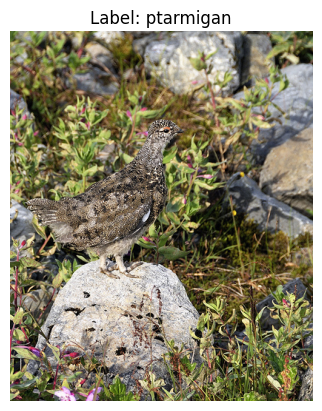

Random Training Images:


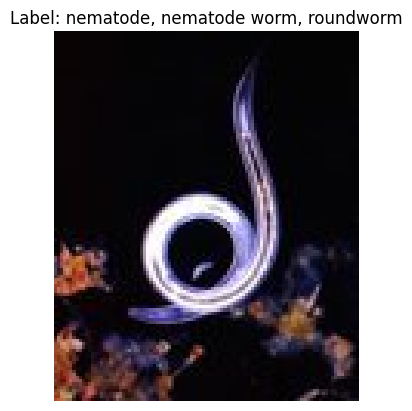

In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 1)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 1)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

# Setting up Dataset and Dataloaders

In [3]:
# Creating the transforms
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Create a custom dataset class
class MultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.samples = []
        self.transform = transform
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

In [5]:
import torchvision.datasets as datasets
# Creating the Datasets
train_dataset = MultiFolderDataset(train_dirs, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [6]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Setting up the Model

In [7]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
!git clone https://github.com/dicarlolab/CORnet.git

Cloning into 'CORnet'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 155 (delta 13), reused 9 (delta 8), pack-reused 135
Receiving objects: 100% (155/155), 68.11 KiB | 1.19 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [9]:
# Navigate to the cloned repository folder
import os
os.chdir('/kaggle/working/CORnet')

# Install the package if needed
!pip install .

Processing /kaggle/working/CORnet
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 897.6 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23228 sha256=5f543da76e9d3f39e5443819c09a2e59e18191f170acb64ff1bb06c0ea28fe59
  Stored in directory: /tmp/pip-ephem-wheel-cache-36mawkde/wheels/ab/bb/f9/8716bf8cc3f23c0cd07d33b31c64ed0bc87023663d6be90ad5
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117031 sha256=827ec5cd71c35a15cfa24b64e85fb49b5e7a8f650e20ad34be00929a1770ca60
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built CORnet fire


In [10]:
# Import the CORnet-S model architecture
from cornet import cornet_s

# Initialize the CORnet-S model
model = cornet_s()

In [11]:
# Replace the final layer to match ImageNet100 classes
import torch.nn as nn

num_classes = 100
model.module.decoder.linear = nn.Linear(in_features=model.module.decoder.linear.in_features, out_features=num_classes)

In [12]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
import torch.nn as nn

# Load the pre-trained weights
checkpoint = torch.load("/kaggle/input/cornet-s/pytorch/default/1/cornet_s-1d3f7974.pth", map_location=device)

# Remove the final layer from the checkpoint to avoid size mismatch
del checkpoint['state_dict']['module.decoder.linear.weight']
del checkpoint['state_dict']['module.decoder.linear.bias']

# Load the rest of the weights into the model
model.load_state_dict(checkpoint['state_dict'], strict=False)  # strict=False ignores the missing final layer

_IncompatibleKeys(missing_keys=['module.decoder.linear.weight', 'module.decoder.linear.bias'], unexpected_keys=[])

In [14]:
# Move model to the appropriate device
model = model.to(device)

# Function to evaluate model performance (pre-training and post-training)
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(loader.dataset)  # Compute validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')
    
    return top1_acc, top5_acc

# Initial evaluation of pre-trained model
print("Evaluating pre-trained model before fine-tuning:")
evaluate_model(model, val_loader)

Evaluating pre-trained model before fine-tuning:


NameError: name 'tqdm' is not defined

In [ ]:
# Ensure CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import necessary modules
import time
from tqdm import tqdm

# Move model to the appropriate device
model = model.to(device)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training phase
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Update running loss

        if i % 100 == 0:  # Print every 100 batches
            print(f"Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)  # Compute epoch loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)  # Compute epoch validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_duration:.2f}s')
    print(f'Train Loss: {epoch_loss:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')

    # Save the model checkpoint
    model_save_path = f'/kaggle/working/cornet_s_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved at {model_save_path}')

print('Training complete')

# Implementing and Evaluating PGD attacks

In [ ]:
!pip install torchattacks

In [ ]:
import torch
import torchattacks
from tqdm import tqdm

# Assuming model, test_loader, and device are already defined

# Initialize PGD attack
pgd_attack = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=40)

# Evaluate model under PGD attack
pgd_correct = 0
pgd_total = 0

model.eval()  # Set model to evaluation mode
for inputs, labels in tqdm(test_loader, desc="PGD Attack Evaluation"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = pgd_attack(inputs, labels)
    
    # Forward pass with adversarial examples
    outputs = model(adv_inputs)
    
    # Calculate accuracy
    _, predicted = outputs.max(1)
    pgd_correct += predicted.eq(labels).sum().item()
    pgd_total += labels.size(0)

# PGD Attack accuracy
pgd_acc = pgd_correct / pgd_total
print(f'PGD Attack Accuracy: {pgd_acc:.4f}')

# Implementing and Evaluating Carlini Wagner Attacks

In [ ]:
# Initialize CW attack
cw_attack = torchattacks.CW(model, c=1e-4, kappa=0, steps=1000, lr=0.01)

# Evaluate model under CW attack
cw_correct = 0
cw_total = 0

model.eval()  # Set model to evaluation mode
for inputs, labels in tqdm(test_loader, desc="CW Attack Evaluation"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = cw_attack(inputs, labels)
    
    # Forward pass with adversarial examples
    outputs = model(adv_inputs)
    
    # Calculate accuracy
    _, predicted = outputs.max(1)
    cw_correct += predicted.eq(labels).sum().item()
    cw_total += labels.size(0)

# CW Attack accuracy
cw_acc = cw_correct / cw_total
print(f'CW Attack Accuracy: {cw_acc:.4f}')